# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTConfig
import tensorflow as tf
import torch.optim as optim
import torch.nn as nn
import torch
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import seaborn as sns
import cv2
from glob import glob
from PIL import Image

Path of Train/Val/Test directories

In [ ]:
# Directory paths
train_path = Path("chest_xray_balanced - Original/train")
val_path = Path("chest_xray_balanced - Original/val")
test_path = Path("chest_xray_balanced - Original/test")

# Data Preprocessing

When working with medical images such as chest X-ray images for classification tasks, it's crucial to consider transforms that could help the model learn better without introducing misleading artifacts.

In [4]:
# Define the custom thresholding function
def apply_cv2_threshold(image, threshold, method):
    """Applies OpenCV thresholding to a PIL image and converts to 3-channel."""
    # Convert PIL image to a NumPy array
    numpy_image = np.array(image)
    # Convert to grayscale if it's not already (assuming image is in RGB format)
    if len(numpy_image.shape) == 3:
        numpy_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2GRAY)
    # Apply thresholding
    _, thresh_image = cv2.threshold(numpy_image, threshold, 255, getattr(cv2, method))
    # Convert the single channel image back to 3 channels by replicating the grayscale channel
    three_channel_image = np.stack([thresh_image]*3, axis=-1)
    # Convert back to PIL image
    pil_image = Image.fromarray(three_channel_image)
    return pil_image

Change the paramters below in accordance with your task

In [5]:
# Custom transformation for thresholding and converting to 3-channel
thresh = 140
method = 'THRESH_TRUNC'
custom_thresholding_transform = transforms.Lambda(lambda img: apply_cv2_threshold(img, thresh , method))

In [ ]:
# target size of images as they are different in sizes (based on paper)
img_size = 224

In [ ]:
train_transforms = transforms.Compose([
    custom_thresholding_transform,  # Apply custom thresholding and convert to 3-channel
    transforms.Resize((img_size, img_size)),  # Resize the image to the desired size
    transforms.RandomRotation(40),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),  # Random affine transformation
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ToTensor(),  # Convert image to PyTorch tensor and scale to [0, 1]
])

# Validation and testing transformations
val_test_transforms = transforms.Compose([
    custom_thresholding_transform,  # Apply custom thresholding and convert to 3-channel
    transforms.Resize((img_size, img_size)),  # Resize the image to the desired size
    transforms.ToTensor(),  # Convert image to PyTorch tensor and scale to [0, 1]
])

label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}

## Data Loaders

To iterate through the dataset in batches.

We also keep another instance of train dataset with the name of `train_eval_loader` for assesing performance at the end.

In [ ]:
batch_size_opt = 32

In [ ]:
# Creating datasets
train_dataset = ImageFolder(train_path, transform=train_transforms)
val_dataset = ImageFolder(val_path, transform=val_test_transforms)
test_dataset = ImageFolder(test_path, transform=val_test_transforms)
train_dataset_eval = ImageFolder(train_path, transform=val_test_transforms)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_opt, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_opt, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_opt, shuffle=False)
train_eval_loader = DataLoader(train_dataset_eval, batch_size=batch_size_opt, shuffle=False)

# Transfer Learning

Use ViT model pre-trained on a dataset and fine tune it on our chest X-rays.

In [ ]:
# Define the ViT configuration
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = 2  # Normal and Pneumonia

# Load the pre-trained model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", config=config)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the output layer to allow fine-tuning
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Utilizing a GPU can drastically reduce the training time for complex models, enabling faster experimentation and development.

In [ ]:
# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
# to see if GPU is activated or not
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Loss and Optimizer**

In [ ]:
lr_opt = 1e-5
epochs_opt = 20

# Updating learning rate in optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr_opt)

**Training and Performance**

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=epochs_opt, patience=3):
    """
    Train the given model using the specified criterion and optimizer.

    Parameters:
        model (torch.nn.Module): The neural network model to be trained.
        criterion: Loss function for optimization.
        optimizer: Optimization algorithm.
        train_loader: Data loader for training data.
        val_loader: Data loader for validation data.
        num_epochs (int): Number of epochs for training (default: epochs_opt).
        patience (int): Number of epochs to wait for improvement in validation accuracy before early stopping (default: 3).

    Returns:
        model (torch.nn.Module): Trained model.
        train_losses (list): List of training losses for each epoch.
        train_accuracies (list): List of training accuracies for each epoch.
        val_losses (list): List of validation losses for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
    """
    train_losses = []  # List to store training loss for each epoch
    train_accuracies = []  # List to store training accuracy for each epoch
    val_losses = []  # List to store validation loss for each epoch
    val_accuracies = []  # List to store validation accuracy for each epoch

    # Early stopping initialization
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False

    # Ensure the directory for saving models exists
    os.makedirs("models_saved", exist_ok=True)

    # Move model to the right device
    model = model.to(device)

    for epoch in range(num_epochs):
        # Check if early stopping criterion is met
        if early_stop:
            print("Early stopping triggered!")
            break

        model.train()  # Set model to training mode
        running_loss = 0.0  # Initialize running loss for this epoch
        correct_preds = 0  # Initialize count of correct predictions
        total_preds = 0  # Initialize count of total predictions

        # Training phase
        train_loop = tqdm(train_loader, leave=True, position=0)  # Progress bar for training loop
        for images, labels in train_loop:
            train_loop.set_description(f"Epoch {epoch+1}/{num_epochs}")  # Update progress description
            images, labels = images.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()  # Zero gradients
            outputs = model(images).logits  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get predicted labels
            correct_preds += (predicted == labels).sum().item()  # Count correct predictions
            total_preds += labels.size(0)  # Count total predictions

            train_loop.set_postfix(loss=running_loss/len(train_loader))  # Update progress bar

        # Compute average training loss and accuracy for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = (correct_preds / total_preds) * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0  # Initialize validation loss
        correct_preds = 0  # Reinitialize count of correct predictions
        total_preds = 0  # Reinitialize count of total predictions

        val_loop = tqdm(val_loader, leave=False, position=0)  # Progress bar for validation loop
        for images, labels in val_loop:
            val_loop.set_description(f"Validating")  # Update progress description
            images, labels = images.to(device), labels.to(device)  # Move data to device

            with torch.no_grad():  # Disable gradient calculation
                outputs = model(images).logits  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_running_loss += loss.item()  # Accumulate loss
                _, predicted = outputs.max(1)  # Get predicted labels
                correct_preds += (predicted == labels).sum().item()  # Count correct predictions
                total_preds += labels.size(0)  # Count total predictions

        # Compute average validation loss and accuracy for this epoch
        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = (correct_preds / total_preds) * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Log metrics for this epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the model
        torch.save(model.state_dict(), f"models_saved/model_ViT_{epoch+1:02d}.pt")

        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True
                print(f"No improvement in validation accuracy for {patience} consecutive epochs, stopping early.")
                break

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [13]:
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=epochs_opt,patience=7)

Epoch 1/20: 100%|██████████| 163/163 [24:09<00:00,  8.89s/it, loss=0.331]


Epoch 1/20, Train Loss: 0.3307, Train Accuracy: 84.99%, Val Loss: 0.2671, Val Accuracy: 89.69%


Epoch 2/20: 100%|██████████| 163/163 [05:42<00:00,  2.10s/it, loss=0.14]


Epoch 2/20, Train Loss: 0.1401, Train Accuracy: 95.61%, Val Loss: 0.1766, Val Accuracy: 94.06%


Epoch 3/20: 100%|██████████| 163/163 [05:42<00:00,  2.10s/it, loss=0.111]


Epoch 3/20, Train Loss: 0.1110, Train Accuracy: 96.17%, Val Loss: 0.1516, Val Accuracy: 94.38%


Epoch 4/20: 100%|██████████| 163/163 [05:41<00:00,  2.10s/it, loss=0.0979]


Epoch 4/20, Train Loss: 0.0979, Train Accuracy: 96.72%, Val Loss: 0.1556, Val Accuracy: 94.06%


Epoch 5/20: 100%|██████████| 163/163 [05:42<00:00,  2.10s/it, loss=0.0853]


Epoch 5/20, Train Loss: 0.0853, Train Accuracy: 97.20%, Val Loss: 0.1611, Val Accuracy: 93.44%


Epoch 6/20: 100%|██████████| 163/163 [05:40<00:00,  2.09s/it, loss=0.0837]


Epoch 6/20, Train Loss: 0.0837, Train Accuracy: 96.97%, Val Loss: 0.1236, Val Accuracy: 95.31%


Epoch 7/20: 100%|██████████| 163/163 [05:40<00:00,  2.09s/it, loss=0.0738]


Epoch 7/20, Train Loss: 0.0738, Train Accuracy: 97.70%, Val Loss: 0.1281, Val Accuracy: 94.69%


Epoch 8/20: 100%|██████████| 163/163 [05:40<00:00,  2.09s/it, loss=0.0686]


Epoch 8/20, Train Loss: 0.0686, Train Accuracy: 97.78%, Val Loss: 0.1155, Val Accuracy: 95.94%


Epoch 9/20: 100%|██████████| 163/163 [05:43<00:00,  2.11s/it, loss=0.0742]


Epoch 9/20, Train Loss: 0.0742, Train Accuracy: 97.35%, Val Loss: 0.1066, Val Accuracy: 96.88%


Epoch 10/20: 100%|██████████| 163/163 [05:44<00:00,  2.11s/it, loss=0.0599]


Epoch 10/20, Train Loss: 0.0599, Train Accuracy: 98.03%, Val Loss: 0.1006, Val Accuracy: 96.25%


Epoch 11/20: 100%|██████████| 163/163 [05:44<00:00,  2.11s/it, loss=0.0587]


Epoch 11/20, Train Loss: 0.0587, Train Accuracy: 97.81%, Val Loss: 0.1072, Val Accuracy: 96.88%


Epoch 12/20: 100%|██████████| 163/163 [05:45<00:00,  2.12s/it, loss=0.0538]


Epoch 12/20, Train Loss: 0.0538, Train Accuracy: 98.12%, Val Loss: 0.1153, Val Accuracy: 96.56%


Epoch 13/20: 100%|██████████| 163/163 [05:45<00:00,  2.12s/it, loss=0.0578]


Epoch 13/20, Train Loss: 0.0578, Train Accuracy: 97.76%, Val Loss: 0.1152, Val Accuracy: 96.25%


Epoch 14/20: 100%|██████████| 163/163 [05:35<00:00,  2.06s/it, loss=0.05]


Epoch 14/20, Train Loss: 0.0500, Train Accuracy: 98.37%, Val Loss: 0.1704, Val Accuracy: 93.44%


Epoch 15/20: 100%|██████████| 163/163 [05:28<00:00,  2.02s/it, loss=0.0559]


Epoch 15/20, Train Loss: 0.0559, Train Accuracy: 97.97%, Val Loss: 0.0935, Val Accuracy: 97.19%


Epoch 16/20: 100%|██████████| 163/163 [05:30<00:00,  2.03s/it, loss=0.0468]


Epoch 16/20, Train Loss: 0.0468, Train Accuracy: 98.35%, Val Loss: 0.0932, Val Accuracy: 97.19%


Epoch 17/20: 100%|██████████| 163/163 [05:40<00:00,  2.09s/it, loss=0.0405]


Epoch 17/20, Train Loss: 0.0405, Train Accuracy: 98.70%, Val Loss: 0.1049, Val Accuracy: 95.62%


Epoch 18/20: 100%|██████████| 163/163 [05:41<00:00,  2.10s/it, loss=0.0459]


Epoch 18/20, Train Loss: 0.0459, Train Accuracy: 98.50%, Val Loss: 0.1186, Val Accuracy: 95.62%


Epoch 19/20: 100%|██████████| 163/163 [05:43<00:00,  2.11s/it, loss=0.0441]


Epoch 19/20, Train Loss: 0.0441, Train Accuracy: 98.26%, Val Loss: 0.0910, Val Accuracy: 95.62%


Epoch 20/20: 100%|██████████| 163/163 [05:47<00:00,  2.13s/it, loss=0.0416]


Epoch 20/20, Train Loss: 0.0416, Train Accuracy: 98.47%, Val Loss: 0.1319, Val Accuracy: 95.00%


## Loss & Accuracy Curves

In [14]:
def plot_loss_from_epoch(train_loss, val_loss, start_epoch):

    # Create an array of epochs
    epochs = range(start_epoch, start_epoch + len(train_loss))

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6), dpi = 200)  # You can adjust the figure size as needed
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss (Starting from Epoch {start_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Set x-ticks to be from 1 to the length of epochs
    plt.xticks(range(1, len(train_loss) + 1))

    # Limit x-axis from 0.5 to the length of your data + 0.5
    plt.xlim(0.5, len(train_loss) + 0.5)

    # Set the y-axis upper bound to 1.05
    plt.ylim()

    plt.grid(True)
    plt.show()

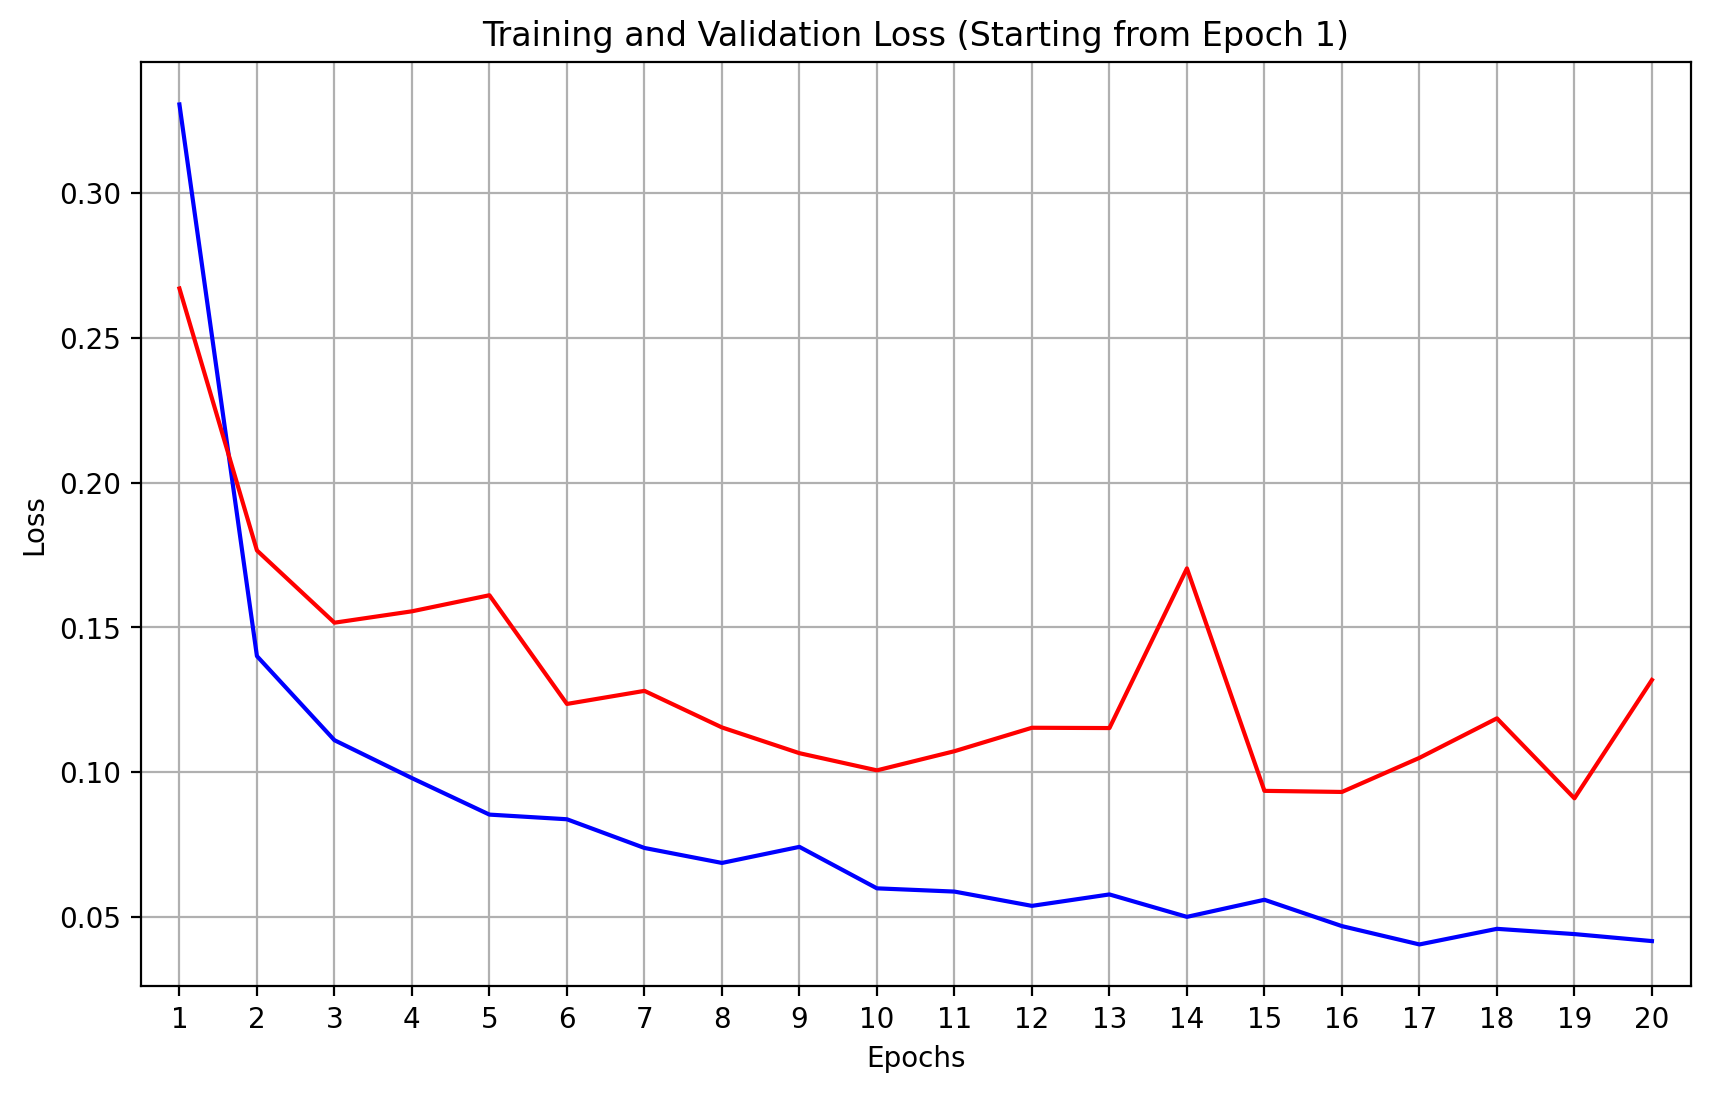

In [15]:
plot_loss_from_epoch(train_losses, val_losses, 1)

In [16]:
import matplotlib.pyplot as plt

def plot_accuracy_from_epoch(train_accuracy, val_accuracy, start_epoch):

    train_accuracy, val_accuracy = np.array(train_accuracy)/100.0, np.array(val_accuracy)/100.0
    # Create an array of epochs
    epochs = range(start_epoch, start_epoch + len(train_accuracy))

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 6), dpi = 200)  # You can adjust the figure size as needed
    plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title(f'Training and Validation accuracy (Starting from Epoch {start_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Set x-ticks to be from 1 to the length of epochs
    plt.xticks(range(1, len(train_accuracy) + 1))

    # Limit x-axis from 0.5 to the length of your data + 0.5
    plt.xlim(0.5, len(train_accuracy) + 0.5)

    # Set the y-axis upper bound to 1.05
    plt.ylim(top=1.0)

    plt.grid(True)
    plt.show()

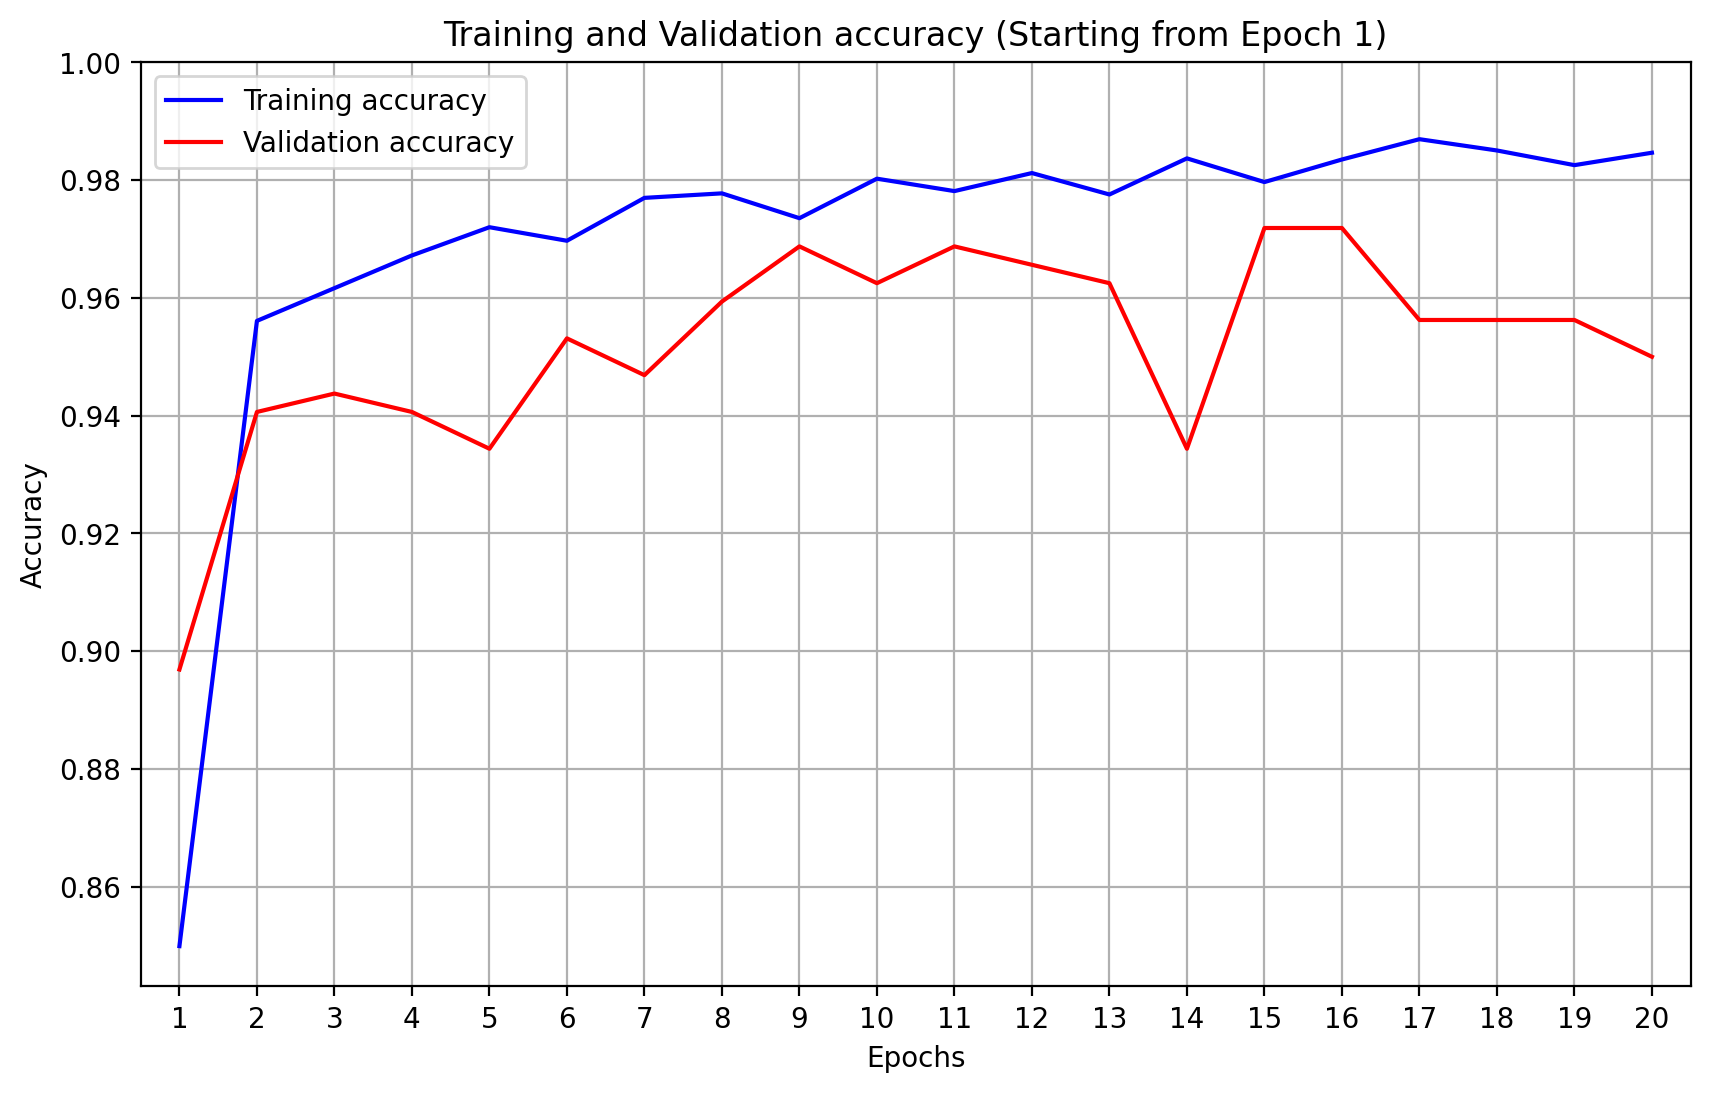

In [17]:
plot_accuracy_from_epoch(train_accuracies, val_accuracies, 1)

## Loding the best model

If the loss curve is smoothing out after each epoch and not being volatile, the best model is the one that has the minimum val loss (and after that the validation loss is constantly going up). *Each model after each epoch is saved. Load them with the follwoing command*.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# To load the model
path_load = "models_saved/model_ViT_16_TRUNC_140.pt"
model.load_state_dict(torch.load(path_load))

**Evaluating the trained ViT Model on Test set**

Train Metrics:
Accuracy: 97.97%
Recall: 97.60%
Precision: 99.66%
F1-Score: 98.62%


Validation Metrics:
Accuracy: 97.19%
Recall: 97.99%
Precision: 97.50%
F1-Score: 97.74%


Test Metrics:
Accuracy: 98.12%
Recall: 98.49%
Precision: 98.49%
F1-Score: 98.49%




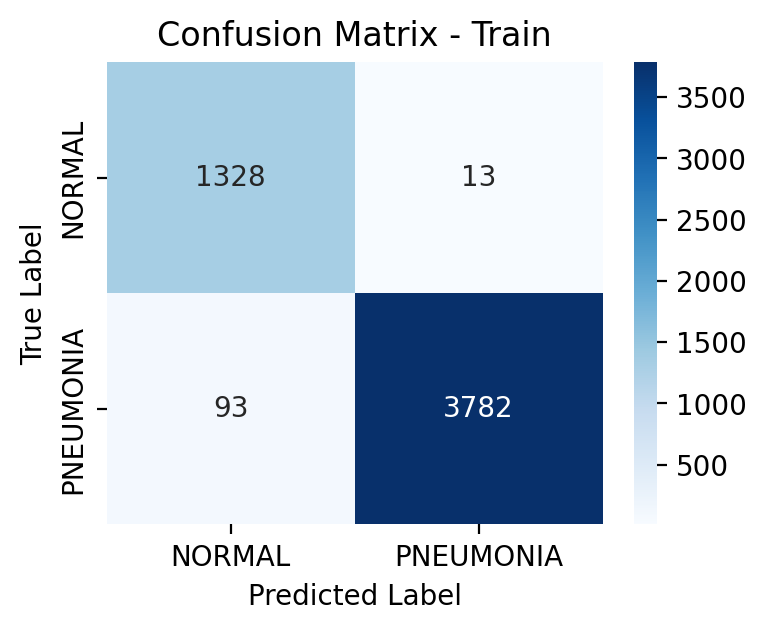

Train - Matthew's Correlation Coefficient: 94.86


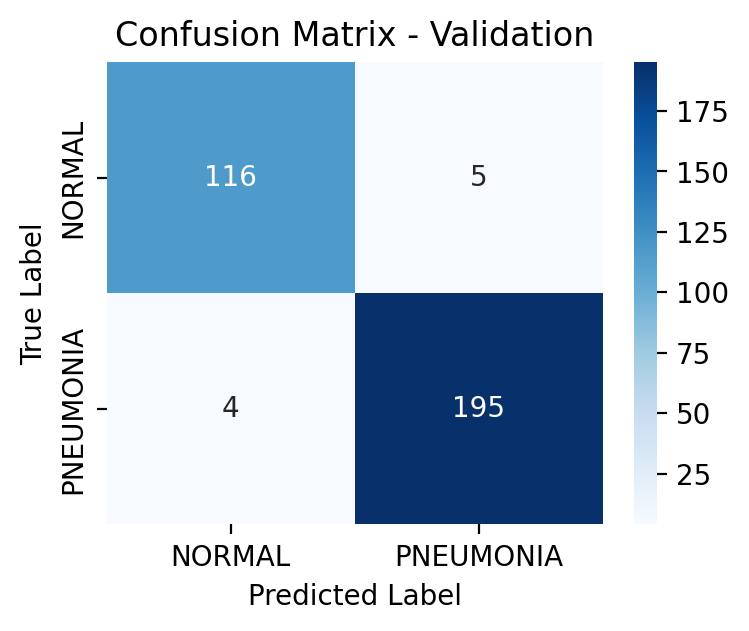

Validation - Matthew's Correlation Coefficient: 94.01


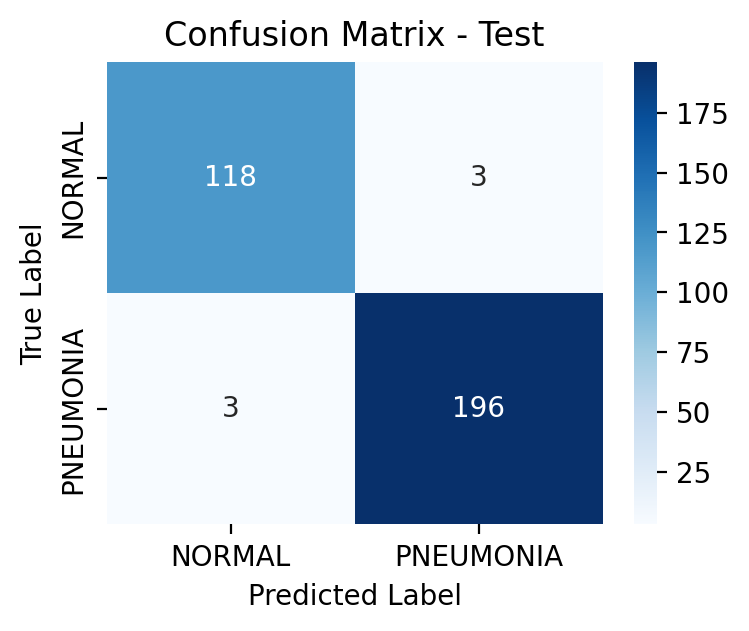

Test - Matthew's Correlation Coefficient: 96.01


In [21]:
def eval_model(model, loader, type_data, device):
    """
    Evaluate the performance of the model on the given dataset loader.

    Parameters:
        model (torch.nn.Module): The neural network model to be evaluated.
        loader: Data loader for the dataset.
        type_data (str): Type of dataset being evaluated (e.g., 'Train', 'Validation', 'Test').
        device: Device to run the evaluation on (e.g., 'cpu', 'cuda').

    Returns:
        metrics (dict): Dictionary containing evaluation metrics (Accuracy, Recall, Precision, F1-Score).
    """
    # Ensure model is in evaluation mode and move it to the right device
    model.eval().to(device)

    all_true_labels, all_predictions = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    metrics = {
        'Accuracy': accuracy_score(all_true_labels, all_predictions) * 100,
        'Recall': recall_score(all_true_labels, all_predictions) * 100,
        'Precision': precision_score(all_true_labels, all_predictions) * 100,
        'F1-Score': f1_score(all_true_labels, all_predictions) * 100
    }

    print(f"{type_data} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}%")
    print("\n")

    return metrics

def plot_cm_and_mcc(y_true, y_pred, classes, title):
    """
    Plot the confusion matrix and compute the Matthews correlation coefficient.

    Parameters:
        y_true: True labels.
        y_pred: Predicted labels.
        classes: List of class labels.
        title (str): Title for the confusion matrix plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3), dpi=200)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

    mcc = matthews_corrcoef(y_true, y_pred) * 100
    print(f"{title} - Matthew's Correlation Coefficient: {mcc:.2f}")

def get_predictions(model, loader, device):
    """
    Get the true and predicted labels for a dataset using the model.

    Parameters:
        model (torch.nn.Module): The neural network model.
        loader: Data loader for the dataset.
        device: Device to run the evaluation on (e.g., 'cpu', 'cuda').

    Returns:
        y_true: True labels.
        y_pred: Predicted labels.
    """
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Assuming 'model', 'device', 'train_eval_loader', 'val_loader', 'test_loader' are defined
train_eval_results = eval_model(model, train_eval_loader, 'Train', device)
val_results = eval_model(model, val_loader, 'Validation', device)
test_results = eval_model(model, test_loader, 'Test', device)

for loader, name in [(train_eval_loader, 'Train'), (val_loader, 'Validation'), (test_loader, 'Test')]:
    y_true, y_pred = get_predictions(model, loader, device)
    plot_cm_and_mcc(y_true, y_pred, ["NORMAL", "PNEUMONIA"], name)